# Modeling de Buró Centralizado

Se prueban inicialmente bajo un train/validation/split los modelos de:

  * Regresión Logística
  * Naive Bayes
  * XGBoost
  * RandomForest
  
Todas las métricas las métricas se loggean en wandb. La idea es revisar qué modelos tienen un performance aparentemente bueno para luego pasarlos por un optimizador

# Set Root

In [ ]:
import os
import re

root = re.findall('.*Proyecto_GE_I', os.getcwd())[0]
os.chdir(root)

# Leer YAML

In [3]:
import yaml

with open('params.yaml', 'r') as file:
    yaml_config = yaml.safe_load(file)

## Importación de Bibliotecas

In [4]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skm
from time import time
from datetime import timedelta
import numpy as np

## Funciones útiles

In [5]:
def get_imbalaced_metrics(y_true, y_preds):
    ths = np.linspace(0, 1, 1000)
    best_th = ths[
        np.argmax([skm.f1_score(y_true, y_preds>th) for th in ths])
    ]
    
    roc_auc = skm.roc_auc_score(y_true, y_preds)
    average_precision = skm.average_precision_score(y_true, y_preds)
    max_f1 = skm.f1_score(y_true, y_preds>best_th)
    accuracy_on_max_f1 = skm.accuracy_score(y_true, y_preds>best_th)
    baseline=y_true.value_counts(True)
    
    return dict(
        roc_auc=roc_auc,
        average_precision=average_precision,
        max_f1=max_f1,
        accuracy_on_max_f1=accuracy_on_max_f1,
        baseline=baseline.iloc[0]
    )

## Carga de Datos

In [6]:
X = pd.read_parquet(
    yaml_config['centralizado']['folder_processed'] +
    'buro_centralizado_from_data_preparation_with_external_variables.parquet'
)
X.sort_values('fecha', inplace=True)

y = pd.read_parquet(
    yaml_config['centralizado']['folder_processed'] +
    'maxima_mora_alcanzada_buro_centralizado_with_recent_bureau.parquet'
).squeeze()
y = y.loc[X.index]

## Definición de variable de mora

Se empleará una maxima mora mayor o igual a 60. La variable objetivo resultante tiene las siguientes propiedades:

```
>> y = y.ge(60).astype(int)
normalize=True
y.value_counts(normalize=True)
0    0.953947
1    0.046053
Name: max_dias_mora, dtype: float64
```

In [7]:
y = y.ge(60).astype(int)

In [8]:
y.value_counts(normalize=True)

0    0.953947
1    0.046053
Name: max_dias_mora, dtype: float64

## Split de los datos

Tanto X como Y están organizados por fechas, se deja un 30% (de fechas posteriores) para test. La validación representa un 20% del set train. En la optimización se hace un 5KFold

In [9]:
X_train_o, X_test, y_train_o, y_test = train_test_split(
    X, y, random_state=42, shuffle=False, test_size=0.3
)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_o, y_train_o, random_state=42, test_size=0.2,
    stratify=y_train_o
)

## Definición de tipos de Variables

Variables que sean más del 50% nulas no serán consideradas inicialmente. También se definen qué variables son categóricas, ordinales y qué variables son numerical.

La única variable que no entra dentro de estas categorías es `fecha` fecha de consulta de buró de crédito.

In [10]:
porcetaje_de_nulidad = (
    X_train.isnull()
    .apply(lambda s: s.value_counts(True)).T
) 

porcetaje_de_nulidad.columns = ['not_null', 'null']
variables_muy_nulas = porcetaje_de_nulidad.query('null > 0.7').index

In [39]:
ordinales = pd.Index(['ip'])
categoricas = X_train.select_dtypes('object').columns
categoricas = categoricas.delete(
    categoricas.isin(ordinales) |
    categoricas.isin(variables_muy_nulas) |
    categoricas.isin(['h3_id'])
)

numericas = X_train.select_dtypes('number').columns
numericas = numericas.delete(
    numericas.isin(variables_muy_nulas)
)

In [12]:
config_ordinal = dict(
    handle_unknown='use_encoded_value',
    unknown_value=np.nan
)
config_onehot = dict(
    handle_unknown='ignore'
)

## PCA

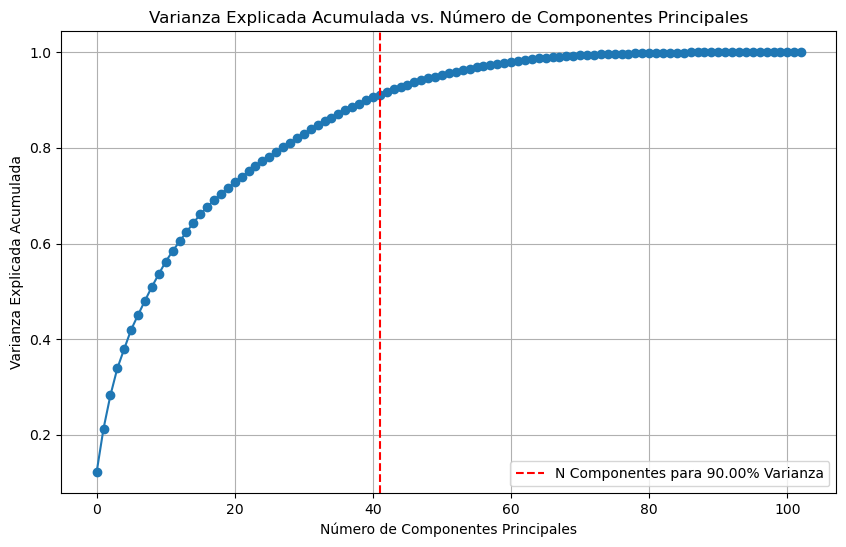

Número de componentes para alcanzar 90.0 % de varianza explicada: 41


In [13]:
numeric_transformer = Pipeline(
    steps=[("imputer",  SimpleImputer(strategy='mean')),
           ("scaler", StandardScaler()),
           ("select_var", VarianceThreshold(0.1))
          ]
)

X_scaled = numeric_transformer.fit_transform(X[numericas])

# Inicializar el modelo PCA
pca = PCA()

pca.fit(X_scaled)

# Varianza explicada acumulada
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

# Encuentra el número de componentes para alcanzar un porcentaje de varianza explicada deseado
target_variance = 0.90  

n_components_to_reach_variance = np.argmax(explained_variance_ratio_cumulative >= target_variance) + 1

# Graficar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio_cumulative, marker='o')
plt.axvline(n_components_to_reach_variance, color='red', linestyle='--', label=f'N Componentes para {target_variance*100:.2f}% Varianza')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada vs. Número de Componentes Principales')
plt.legend()
plt.grid(True)
plt.show()

print('Número de componentes para alcanzar', target_variance*100, '% de varianza explicada:', n_components_to_reach_variance)



## RL

In [25]:
numeric_transformer = Pipeline(
    steps=[("imputer",  SimpleImputer(strategy='mean')),
           ("scaler", StandardScaler()),
           ("select_var", VarianceThreshold(0.1)), ("pca", PCA(
               n_components=41))
           ]
)

categorical_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='most_frequent')),
           ('dumm', OneHotEncoder(**config_onehot)),
           ("selector", SelectPercentile(chi2, percentile=50))
           ]
)

ordinal_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='most_frequent')),
           ('encod', OrdinalEncoder(**config_ordinal))
           ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numericas),
     #   ("ord", ordinal_transformer, ordinales),
        ("cat", categorical_transformer, categoricas),
    ]
)


In [28]:
rl_pipeline = Pipeline([
    ('preprocesamiento', preprocessor),
    ('classificador', LogisticRegression())
])

start = time()
rl_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento Regresión Logistica:',
    str(timedelta(seconds=end-start))
)


Tiempo Entrenamiento Regresión Logistica: 0:00:00.628677


In [42]:
rl_pipeline

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('select_var',
                                                                   VarianceThreshold(threshold=0.1)),
                                                                  ('pca',
                                                                   PCA(n_components=41))]),
                                                  Index(['riesgo_score', 'riesgo_6', 'fidelidad_tc', 'uso_exigible',
       'uso_tc_cant', 'uso_tc_cant_a', 'uso_tc_saldo', 'uso_tc_limite',...
       'price_mean_lote_venta', 'price_var_casa_venta'],
      dtype='object', length=103)),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('dumm',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x00000150154C3F70>))]),
                                                  Index(['riesgo_12', 'riesgo_12_bis'], dtype='object'))])),
                ('classificador', LogisticRegression())])

In [30]:
rl_val_preds = rl_pipeline.predict_proba(X_val)[:, 1]
rl_metrics = get_imbalaced_metrics(y_val, rl_val_preds)
rl_metrics

{'roc_auc': 0.7043260780407781,
 'average_precision': 0.09974126052601137,
 'max_f1': 0.18285714285714286,
 'accuracy_on_max_f1': 0.8272350707628582,
 'baseline': 0.9530548843631342}

In [33]:
 #(y_val.to_frame(name='y_true').assign(y_pred_proba=rl_val_preds)).to_excel('preds.xlsx')

## Naive Bayes

In [26]:
nb_pipeline = Pipeline([
    ('preprocesamiento', preprocessor),
    ('classificador', GaussianNB())
])

start = time()
nb_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento Naive Bayes:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento Naive Bayes: 0:00:00.506600


In [27]:
nb_val_preds = nb_pipeline.predict_proba(X_val)[:, 1]
nb_metrics = get_imbalaced_metrics(y_val, nb_val_preds)
nb_metrics

{'roc_auc': 0.6547206894347742,
 'average_precision': 0.0772830622109653,
 'max_f1': 0.14710884353741494,
 'accuracy_on_max_f1': 0.6537797721781153,
 'baseline': 0.9530548843631342}

## XGBoost


Tiempo de Entrenamiento en train: 0:00:25.777025

### Definición del Preprocesamiento

In [25]:
xgb_preprocessing = ColumnTransformer([
    ('procesador_numericas', 'passthrough', numericas),
    ('proccesador_ordinal', OrdinalEncoder(**config_ordinal), ordinales),
    ('procesador_categoricas', OneHotEncoder(), categoricas)
])

### Definicion del pipeline y entrenamiento

In [26]:
config_xgb = dict(
    use_label_encoder=False, eval_metric='logloss'
)

xgb_pipeline = Pipeline([
    ('preprocesamiento', xgb_preprocessing),
    ('classificador', XGBClassifier(**config_xgb))
])

start = time()
xgb_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento XGBoost:',
    str(timedelta(seconds=end-start))
)

C:\Users\danie\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Tiempo Entrenamiento XGBoost: 0:00:02.727729


### Revisión de Métricas

In [27]:
xgb_val_preds = xgb_pipeline.predict_proba(X_val)[:, 1]
xgb_metrics = get_imbalaced_metrics(y_val, xgb_val_preds)
xgb_metrics

{'roc_auc': 0.7146011542067026,
 'average_precision': 0.10653539459509109,
 'max_f1': 0.19024390243902436,
 'accuracy_on_max_f1': 0.8853986882982395,
 'baseline': 0.9530548843631342}

## RandomForest

Uso el mismo preprocesamiento que el XGBoost. Sin embargo usa un SimplerImputer de la media ya que las variables categoricas tras el OneHotEncoder tienen un columna para los valores nulos.

Tiempo de Entrenamiento: 0:00:22.465637

In [28]:
rf_pipeline = Pipeline([
    ('preprocesamiento', xgb_preprocessing),
    ('imptuer', SimpleImputer()),
    ('classificador', RandomForestClassifier())
])

start = time()
rf_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento RandomForest:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento RandomForest: 0:00:09.000536


In [29]:
rf_val_preds = rf_pipeline.predict_proba(X_val)[:, 1]
rf_metrics = get_imbalaced_metrics(y_val, rf_val_preds)
rf_metrics

{'roc_auc': 0.6616615090440376,
 'average_precision': 0.0897057334274327,
 'max_f1': 0.16949152542372878,
 'accuracy_on_max_f1': 0.8139454608215395,
 'baseline': 0.9530548843631342}

## Resumen de Resultados

In [30]:
metrics = dict(
    xgb=xgb_metrics,
    rf=rf_metrics,
    rl=rl_metrics,
    nb=nb_metrics
)

df_metrics = pd.DataFrame.from_dict(metrics, orient='index')

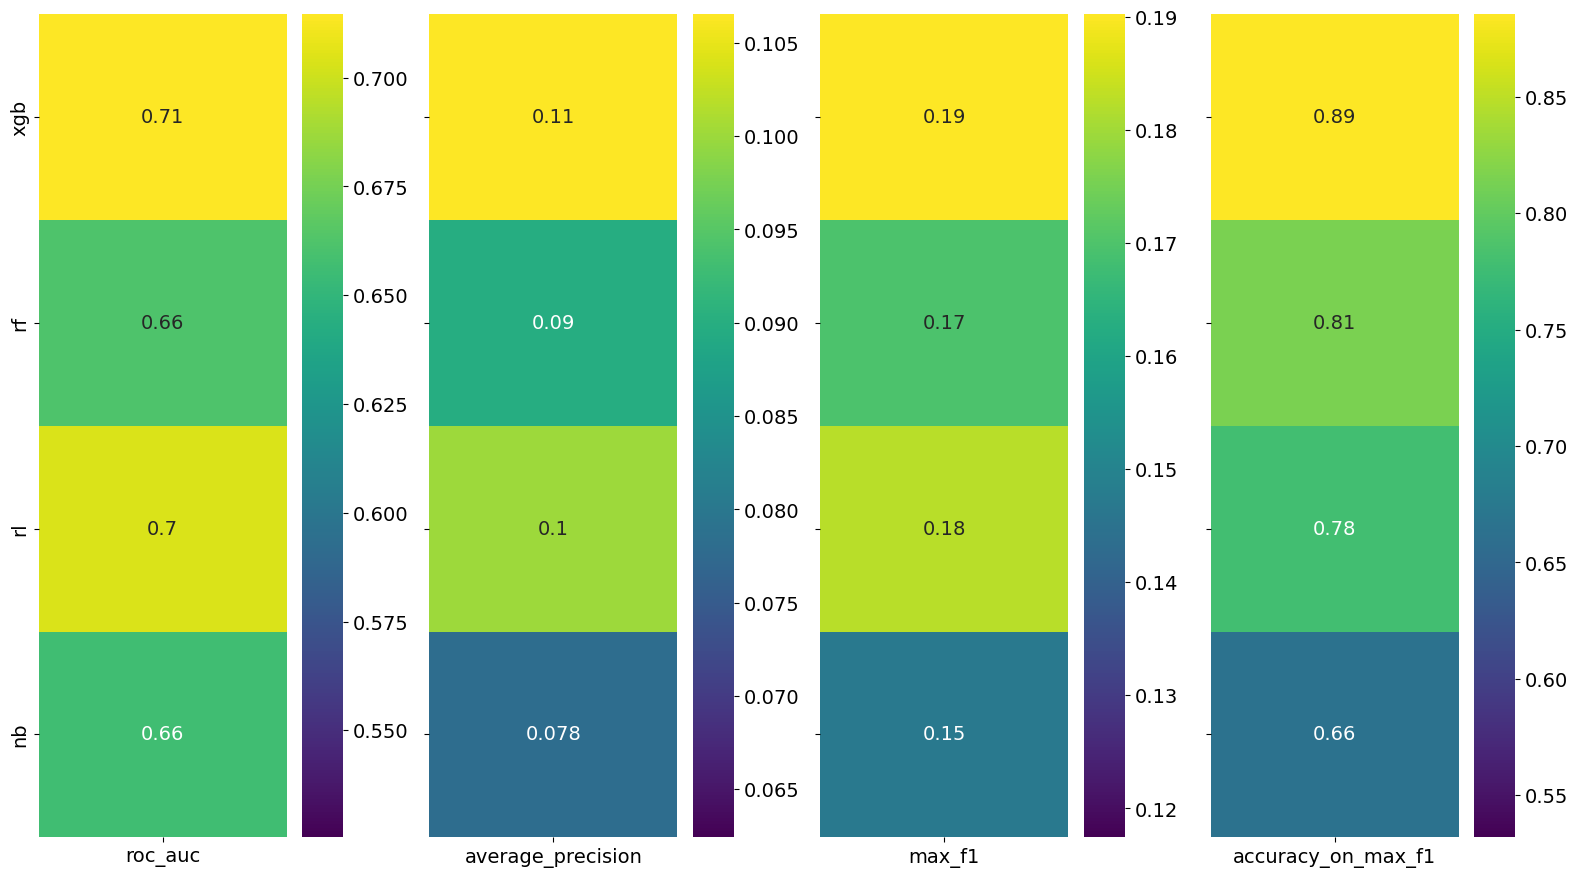

In [31]:
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14)

fig, axs = plt.subplots(1, 4, figsize=(16, 9), sharey=True)

for i, ax in enumerate(axs):
    sns.heatmap(
        df_metrics.iloc[:, [i]],
        ax=ax,
        vmin=df_metrics.iloc[:, [i]].min()*0.8,
        vmax=df_metrics.iloc[:, [i]].max(),
        annot=True,
        cmap='viridis'
    )
    
fig.tight_layout()